In [108]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
# from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np

from netCDF4 import Dataset
# from skimage import transform
from plot_picture_function import set_map_ticks,add_Chinese_provinces
from datetime import timedelta
import cartopy.crs as ccrs

from scipy import stats

In [109]:
dataset= xr.open_dataset('E:/ZiYuanPingGu/result_2022/SCQA829_202210.nc')#读取ERA5 202001整日数据
dataset #修改dims lat lon time

<xarray.Dataset>
Dimensions:      (time: 744, phase: 3, lat1: 161, lon1: 221, lat2: 33, lon2: 45, lat3: 81, lon3: 111)
Dimensions without coordinates: time, phase, lat1, lon1, lat2, lon2, lat3, lon3
Data variables:
    ERA5_data    (time, phase, lat1, lon1) float64 ...
    JRA55_data   (time, phase, lat2, lon2) float64 ...
    MERRA2_data  (time, phase, lat3, lon3) float64 ...

In [110]:
#需要ERA5 cloud_cover
dataERA5 = xr.open_dataset(r'E:\ZiYuanPingGu\2022_ERA5\ERA5-col-202210.nc')#读取ERA5 202001数据
dataERA5

<xarray.Dataset>
Dimensions:    (longitude: 221, latitude: 161, time: 120)
Coordinates:
  * longitude  (longitude) float32 80.0 80.25 80.5 80.75 ... 134.5 134.8 135.0
  * latitude   (latitude) float32 55.0 54.75 54.5 54.25 ... 15.5 15.25 15.0
  * time       (time) datetime64[ns] 2022-10-01 ... 2022-10-30T18:00:00
Data variables:
    tcc        (time, latitude, longitude) float32 ...
    tciw       (time, latitude, longitude) float32 ...
    tclw       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-27 08:46:23 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [111]:
dataset.ERA5_data[:,2,:,:].shape

(744, 161, 221)

In [112]:
lwp_ERA5array = np.stack(dataERA5.tclw.values, axis=2)
iwp_ERA5array = np.stack(dataERA5.tciw.values, axis=2)#转换维度
lwp_H8ori = np.stack(dataset.ERA5_data[:-24:6,0,:,:], axis=2)
iwp_H8ori = np.stack(dataset.ERA5_data[:-24:6,1,:,:], axis=2)
clc_ERA5array = np.stack(dataERA5.tcc.values, axis=2)
cs_ERA5array = np.zeros(clc_ERA5array.shape)
cs_ERA5array[clc_ERA5array > 0.8] = 1#将总云量大于0.8的值赋为1，认作为该格点为云
# lwp_ERA5array.shape
#云检测处理，取两者交集
clc_H8array = np.stack(dataset.ERA5_data[:-24:6,2,:,:], axis=2)
clc_Botharray = clc_H8array * cs_ERA5array#做交集处理
lwp_H8ori[lwp_H8ori == -1] = np.nan
iwp_H8ori[iwp_H8ori == -1] = np.nan
# dataset.H8_lwp.data[dataset.H8_lwp.data == -327] = np.nan
# dataset.H8_iwp.data[dataset.H8_iwp.data == -327] = np.nan

Bias_lwparray = lwp_ERA5array - lwp_H8ori #做差，得到偏差矩阵，下同
Bias_iwparray = iwp_ERA5array - iwp_H8ori

Bias_lwparray[clc_Botharray == 0] = np.nan
Bias_iwparray[clc_Botharray == 0] = np.nan

In [113]:
#这里将nan转为具体值，避免后续求平均等操作会警告
Bias_lwparray[np.isnan(Bias_lwparray)] = -327
Bias_iwparray[np.isnan(Bias_iwparray)] = -327
lwp_H8ori[np.isnan(lwp_H8ori)] = -327
iwp_H8ori[np.isnan(iwp_H8ori)] = -327

In [114]:
#以0.025为间隔统计对应期间的H8的lwp和iwp的平均值和标准差
# dataset.Bias_lwp.data
# dataset.H8_lwp
def Getbias_Mean_STD(data, data_bias, looptime):
#     xdict = {} 
#     step = 0.025
#     xspace = np.linspace(0, 1, 41)
#     #建立空xdict
#     for lownum in range(0,len(xspace)-1):
#         xdict[str(xspace[lownum])] = np.empty([0])

#     for itime in range(dataset.dims['time']):
#         onetimedata = dataset.H8_lwp[:,:,itime].data
#         onetimedata_bias = dataset.Bias_lwp[:,:,itime].data
#         for lownum in range(0,len(xspace)-1):#-1为了不取1
#             if ((onetimedata < xspace[lownum]+step) & (onetimedata > xspace[lownum])).any():
#                 xdict[str(xspace[lownum])] = \
#                 np.hstack([xdict[str(xspace[lownum])],\
#                           onetimedata_bias[(onetimedata < \
#                                             xspace[lownum]+step) & (onetimedata > xspace[lownum])]])
    xdict = {}#创建空字典
    step = 0.025#间隔
    xspace = np.linspace(0, 1, 41)#将0-1划分为共41个离散区间
    #建立空xdict
    for lownum in range(0,len(xspace)-1):
        xdict[str(xspace[lownum])] = np.empty([0])

    for itime in range(looptime):
        onetimedata = data[:,:,itime].data#获取一层源数据
        onetimedata_bias = data_bias[:,:,itime]#获取一层偏差矩阵数据
        for lownum in range(0,len(xspace)-1):#-1为了不取1
            if ((onetimedata < xspace[lownum]+step) & (onetimedata > xspace[lownum])).any():#判断在哪个区间
                #获取有效值的索引
                valid_index = (onetimedata < xspace[lownum]+step) &(onetimedata > \
                                                                    xspace[lownum]) & (onetimedata_bias != -327)
                xdict[str(xspace[lownum])] = \
                np.hstack([xdict[str(xspace[lownum])], onetimedata_bias[valid_index]])#数据横向叠加
    return xdict
xdict_lwp = Getbias_Mean_STD(lwp_H8ori, Bias_lwparray, 120)#返回每个离散区间云水数据，字典类型
xdict_iwp = Getbias_Mean_STD(iwp_H8ori, Bias_iwparray, 120)

In [115]:
def Get_statistic_dict(datadict):
    statistic_dict = {}
    for keyname in datadict.keys():
        Mean = round(
            np.mean(datadict[keyname]), 4#求平均
        )
        Std = round(
            np.std(datadict[keyname]), 4#求标准差
        )
        statistic_dict[keyname] = (Mean, Std)
    return statistic_dict

statistic_dict_lwp = Get_statistic_dict(xdict_lwp)
statistic_dict_iwp = Get_statistic_dict(xdict_iwp)

In [116]:
#计算所有数据的平均值，标准差，均方根误差
valid_Biaslwpdata = np.empty([0])
valid_Biasiwpdata = np.empty([0])
for itime in range(120):
    onetimedata_lwp = Bias_lwparray[:,:,itime]
    onetimedata_iwp = Bias_iwparray[:,:,itime]
    valid_Biaslwpdata = \
    np.hstack([valid_Biaslwpdata,onetimedata_lwp[onetimedata_lwp != -327]])
    valid_Biasiwpdata = \
    np.hstack([valid_Biasiwpdata,onetimedata_iwp[onetimedata_iwp != -327]])

STD_lwp = np.std(valid_Biaslwpdata)
STD_iwp = np.std(valid_Biasiwpdata)
MEAN_lwp = np.mean(valid_Biaslwpdata)
MEAN_iwp = np.mean(valid_Biasiwpdata)

In [117]:
RMSE_lwp = np.sqrt(sum(valid_Biaslwpdata**2)/len(valid_Biaslwpdata))
RMSE_iwp = np.sqrt(sum(valid_Biasiwpdata**2)/len(valid_Biasiwpdata))

In [118]:
print(RMSE_lwp, RMSE_iwp)
print(STD_lwp, STD_iwp)
print(MEAN_lwp, MEAN_iwp)

0.24204531264820622 0.5665594957053303
0.21925650527445095 0.4894368694205726
0.10253057236649997 -0.2853790690041357


In [119]:
#计算云水、云冰在空间上的分布情况，月平均值
def Get_stack(dataset, looptime):
    data_stack = np.zeros([161, 221, looptime])
    Countvalid_stack = np.zeros([161, 221])
    for itime in range(looptime):
        onetimedata = dataset[:,:,itime]
        Countvalid_stack[onetimedata != -327] += 1
        data_stack[:,:,itime][onetimedata != -327] = onetimedata[onetimedata != -327]
    return data_stack.sum(axis=2), Countvalid_stack

# stack_lwparray, Countvalid_stack_lwp= Get_stack(dataset.Bias_lwp.data, dataset.dims['time'])
# stack_iwparray, Countvalid_stack_iwp= Get_stack(dataset.Bias_iwp.data, dataset.dims['time'])

def Get_origin_stack(dataset1, dataset2, looptime):
    data_stack1 = np.zeros([161, 221, looptime])#创建空矩阵，下同
    data_stack2 = np.zeros([161, 221, looptime])
    Countvalid_stack = np.zeros([161, 221])#统计垂直方向上的有效数据的个数
    for itime in range(looptime):
        onetimedata1 = dataset1[:,:,itime]
        onetimedata2 = dataset2[:,:,itime]
        Countvalid_stack[onetimedata1 != -327] += 1#计算每个平面格点上垂直方向上的有效格点数量
        data_stack1[:,:,itime][onetimedata1 != -327] = onetimedata1[onetimedata1 != -327]#提取有效数据
#         data_stack2[:,:,itime][onetimedata1 != -327] = onetimedata2[onetimedata1 != -327]
        data_stack2[:,:,itime][onetimedata1 != -327] = onetimedata2[onetimedata1 != -327]
    Mean_sum1 = data_stack1.sum(axis=2)/Countvalid_stack
    Mean_sum2 = data_stack2.sum(axis=2)/Countvalid_stack
    Mean_sum3 = dataset2.sum(axis=2)/looptime
    
    Mean_sum1[Countvalid_stack == 0] = np.nan
    Mean_sum2[Countvalid_stack == 0] = np.nan
    return Mean_sum1, Mean_sum2, Mean_sum3, Countvalid_stack
H8array_lwp, ERA5array_lwp, addERA5_lwp, Countvalid_stack_lwp = Get_origin_stack(lwp_H8ori, lwp_ERA5array, 120)
#返回值H8_LWP的月平均,ERA5_LWP的月平均，ERA5_LWP的月平均（计算方式不同）, 垂直方向上的平面格点统计矩阵
H8array_iwp, ERA5array_iwp, addERA5_iwp, Countvalid_stack_iwp = Get_origin_stack(iwp_H8ori, iwp_ERA5array, 120)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14488\1620772644.py:25: RuntimeWarning: invalid value encountered in true_divide
  Mean_sum1 = data_stack1.sum(axis=2)/Countvalid_stack
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14488\1620772644.py:26: RuntimeWarning: invalid value encountered in true_divide
  Mean_sum2 = data_stack2.sum(axis=2)/Countvalid_stack


In [120]:
x = np.linspace(80.0, 135.0, 221)
y = np.linspace(55.0, 15.0, 161)
X, Y = np.meshgrid(x, y)

In [121]:
array_Biaslwp = ERA5array_lwp - H8array_lwp
array_Biasiwp = ERA5array_iwp - H8array_iwp

In [122]:
Biaslwp_f = array_Biaslwp.flatten()
Biaslwp_n = Biaslwp_f[~np.isnan(Biaslwp_f)]
np.mean(Biaslwp_n), np.sqrt(np.sum(Biaslwp_n**2)/len(Biaslwp_n)), np.std(Biaslwp_n)

(0.02143436499461645, 0.15047809422960326, 0.14894369687989795)

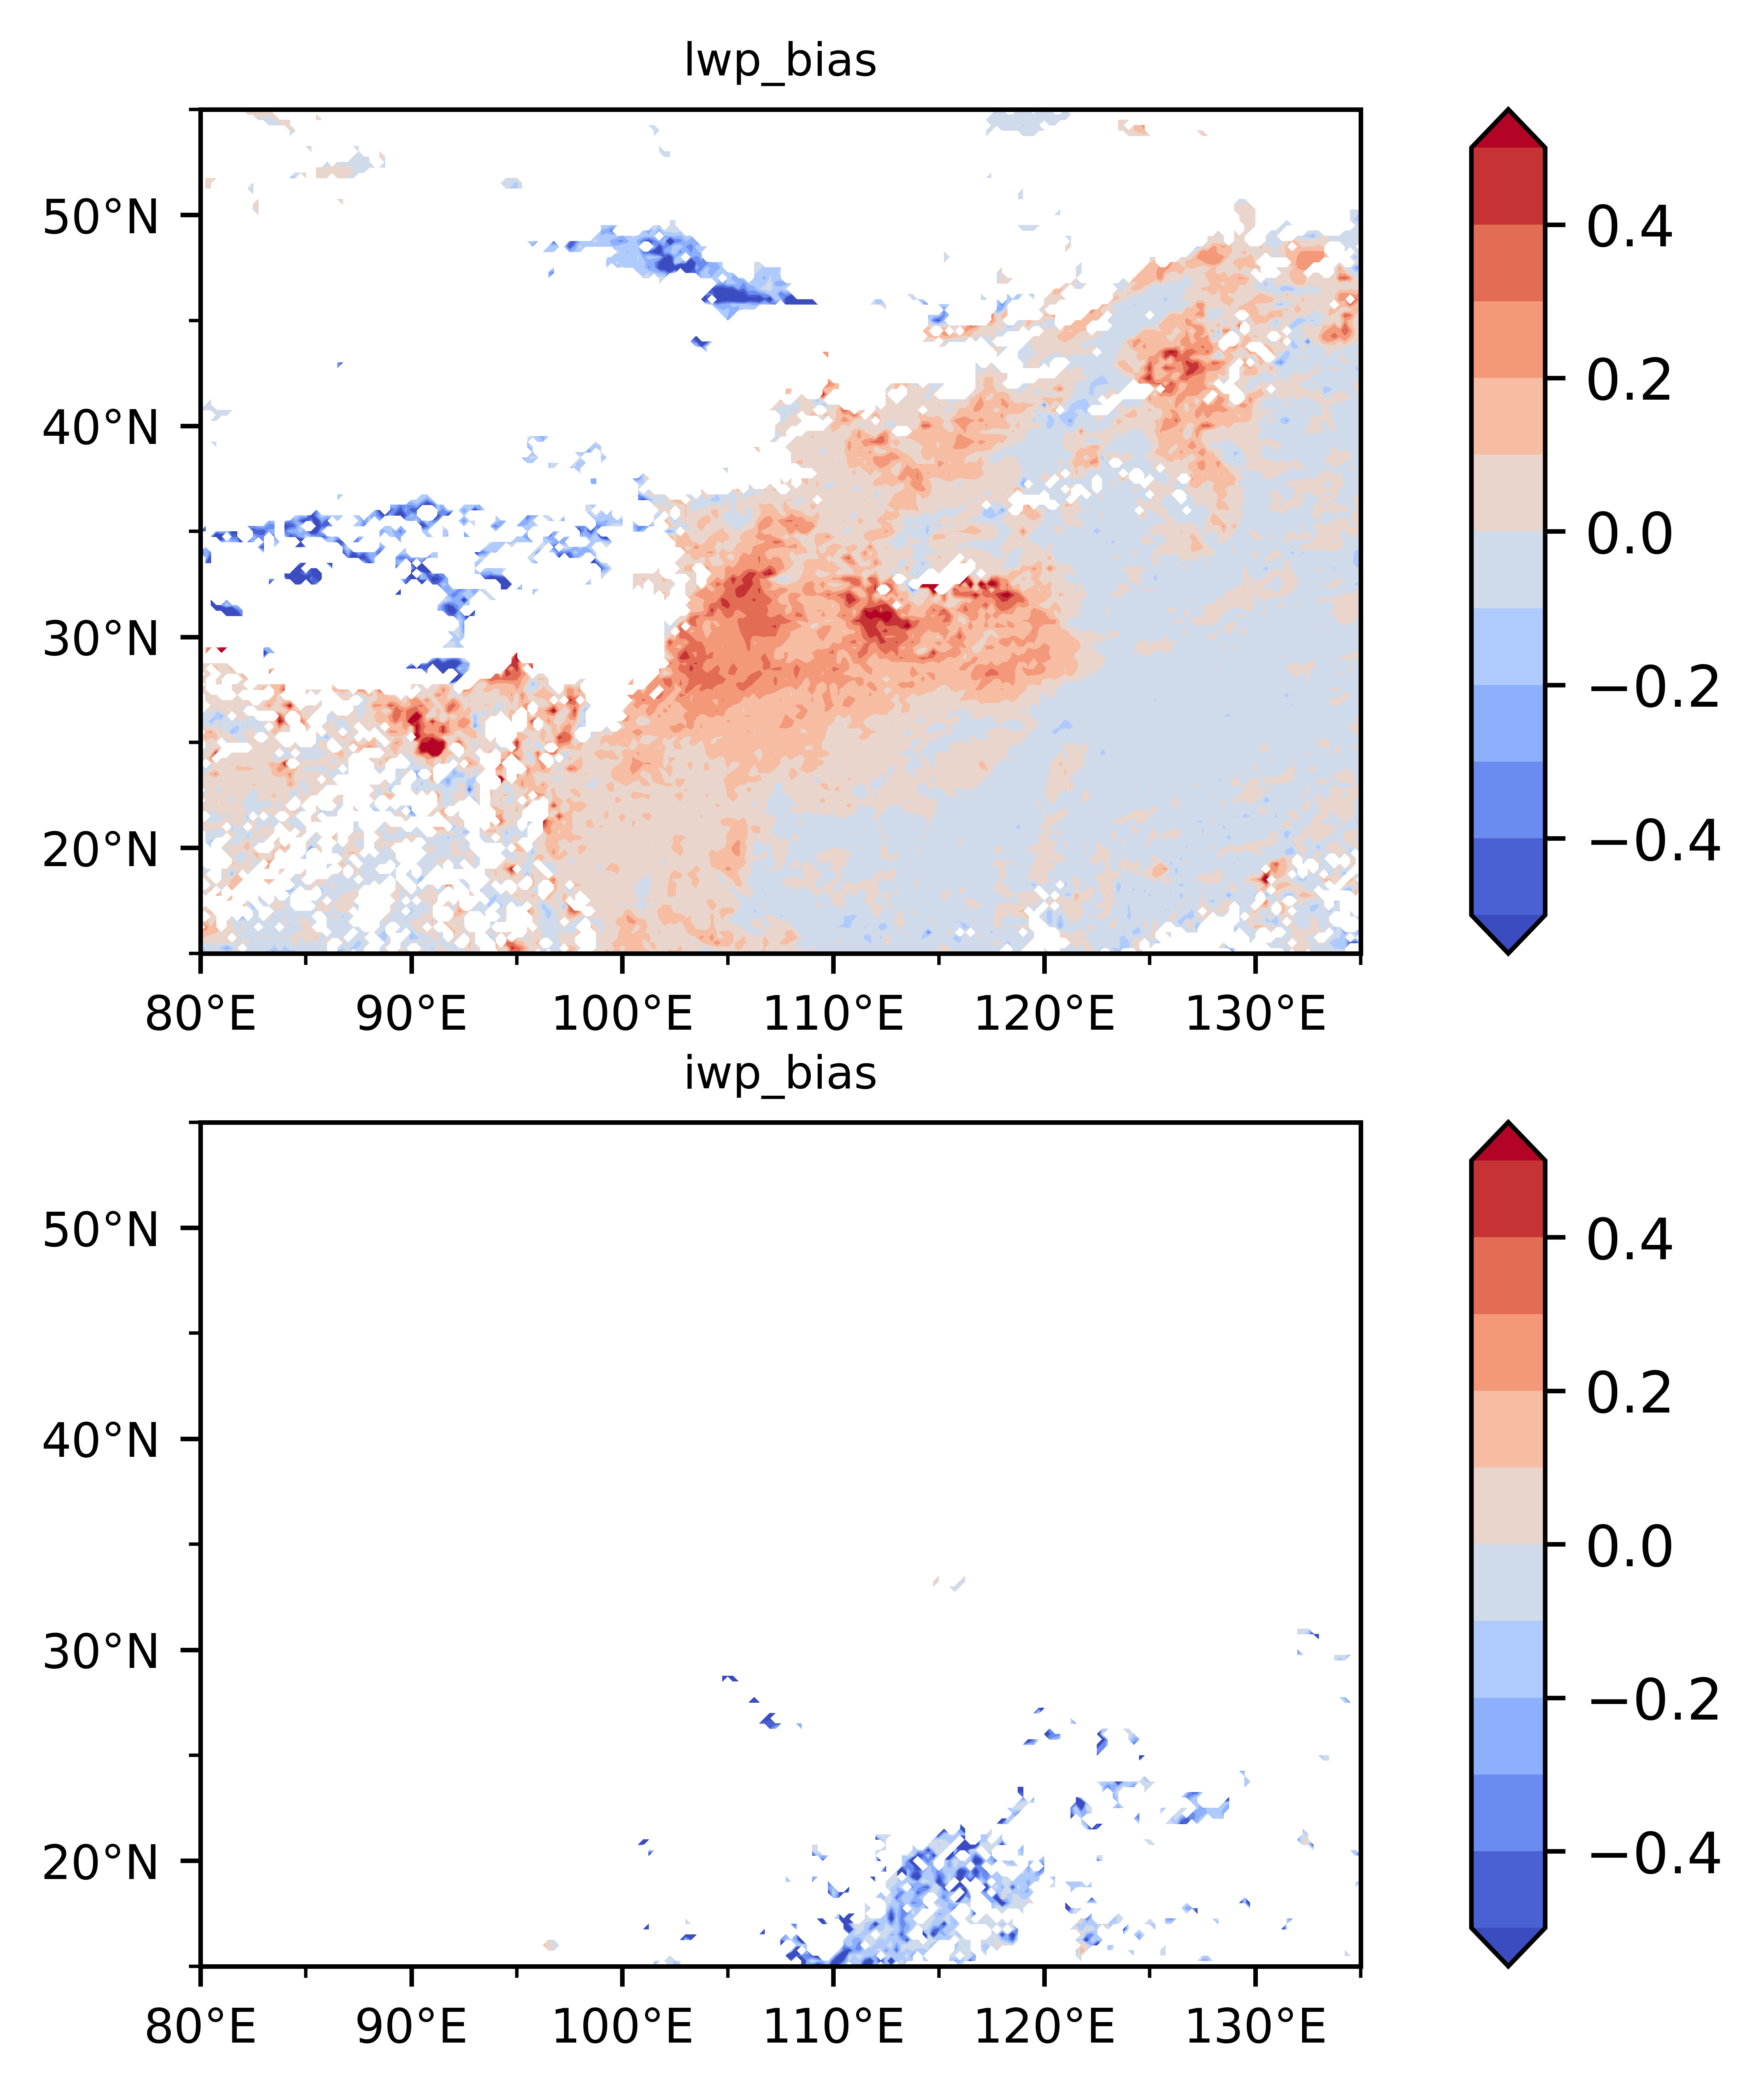

In [123]:
def Plot_2_pic(data1, data2, picname, title1, title2, colorp):#绘图自定义，重复代码，不作解释
    extent = [80, 135, 15, 55]#100E--110E,25N--35N
    proj = ccrs.PlateCarree()#选择投影方式，平面投影
    fig = plt.figure(figsize=(9,6), dpi=1000)
    ax1 = fig.add_subplot(211, projection=proj)#创建一个轴，或者是说主体
    # 设置经纬度刻度.
    set_map_ticks(ax1, dx=10, dy=10, nx=1, ny=1, labelsize='small')#自定义函数set_map_tick
    ax1.set_extent(extent, crs=proj)
    ax1.set_title(title1, fontsize=8)
    # im = plt.pcolormesh(lon_mesh, lat_mesh, dem_data,cmap = "rainbow")
#     levels = [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    levels = np.linspace(-0.5, 0.5, 11)
    im1 = ax1.contourf(X, Y, data1, cmap = colorp, levels = levels, extend='both')
#     add_Chinese_provinces(ax1, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    #设置colorbar的位置
    cax1 = fig.add_axes([ax1.get_position().x1 + 0.03, ax1.get_position().y0, 0.02, ax1.get_position().height])
    plt.colorbar(im1, cax=cax1)

    ax2 = fig.add_subplot(212, projection=proj)#创建一个轴，或者是说主体
    # 设置经纬度刻度.
    set_map_ticks(ax2, dx=10, dy=10, nx=1, ny=1, labelsize='small')#自定义函数set_map_tick
    ax2.set_extent(extent, crs=proj)
    ax2.set_title(title2, fontsize=8)
    # im = plt.pcolormesh(lon_mesh, lat_mesh, dem_data,cmap = "rainbow")
#     levels = np.linspace(-1.5, 1.5, 11)
#     levels = np.linspace(0, 0.1, 11)
    im2 = ax2.contourf(X, Y, data2, cmap = colorp, levels = levels, extend='both')
#     add_Chinese_provinces(ax2, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    #设置colorbar的位置
    cax2 = fig.add_axes([ax2.get_position().x1 + 0.03, ax2.get_position().y0, 0.02, ax2.get_position().height])
    plt.colorbar(im2, cax=cax2)
#     plt.savefig(f'D:/python project/python_qixianglianxi/ZiYuanPingGu/analyze_draw/{picname}.png',
#                 dpi=100,
#                 bbox_inches = 'tight'
#     #             facecolor = 'g',
#     #             edgecolor = 'b'
#                )
    plt.show()
# levels = [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]    
Plot_2_pic(array_Biaslwp, array_Biasiwp, 'bias_lwp_01', 'lwp_bias', 'iwp_bias', 'coolwarm')

In [124]:
# lwp_biasarray = dataset.Bias_lwp.data
# lwp_biasarray[0].shape

In [125]:
# lwp_H8array = dataset.H8_lwp.data
# iwp_H8array = dataset.H8_iwp.data

In [126]:
# ERA5array_lwp

In [127]:
def Plot_22_pic(data1, data2, picname, title1, title2, colorp):
    extent = [80, 135, 15, 55]#100E--110E,25N--35N
    proj = ccrs.PlateCarree()#选择投影方式，平面投影
    fig = plt.figure(figsize=(9,6), dpi=1000)
    ax1 = fig.add_subplot(211, projection=proj)#创建一个轴，或者是说主体
    # 设置经纬度刻度.
    set_map_ticks(ax1, dx=10, dy=10, nx=1, ny=1, labelsize='small')#自定义函数set_map_tick
    ax1.set_extent(extent, crs=proj)
    ax1.set_title(title1, fontsize=8)
    # im = plt.pcolormesh(lon_mesh, lat_mesh, dem_data,cmap = "rainbow")
#     levels = [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    levels = np.linspace(0, 0.6, 11)
    im1 = ax1.contourf(X, Y, data1, cmap = colorp, levels = levels, extend='max')
#     add_Chinese_provinces(ax1, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    #设置colorbar的位置
    cax1 = fig.add_axes([ax1.get_position().x1 + 0.03, ax1.get_position().y0, 0.02, ax1.get_position().height])
    plt.colorbar(im1, cax=cax1)

    ax2 = fig.add_subplot(212, projection=proj)#创建一个轴，或者是说主体
    # 设置经纬度刻度.
    set_map_ticks(ax2, dx=10, dy=10, nx=1, ny=1, labelsize='small')#自定义函数set_map_tick
    ax2.set_extent(extent, crs=proj)
    ax2.set_title(title2, fontsize=8)
    # im = plt.pcolormesh(lon_mesh, lat_mesh, dem_data,cmap = "rainbow")
    levels = np.linspace(0, 0.6, 11)
#     levels = np.linspace(0, 0.1, 11)
    im2 = ax2.contourf(X, Y, data2, cmap = colorp, levels = levels, extend='max')
#     add_Chinese_provinces(ax2, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    #设置colorbar的位置
    cax2 = fig.add_axes([ax2.get_position().x1 + 0.03, ax2.get_position().y0, 0.02, ax2.get_position().height])
    plt.colorbar(im2, cax=cax2)
#     plt.savefig(f'D:/python project/python_qixianglianxi/ZiYuanPingGu/analyze_draw/{picname}.png',
#                 dpi=100,
#                 bbox_inches = 'tight'
#     #             facecolor = 'g',
#     #             edgecolor = 'b'
#                )
    plt.show()

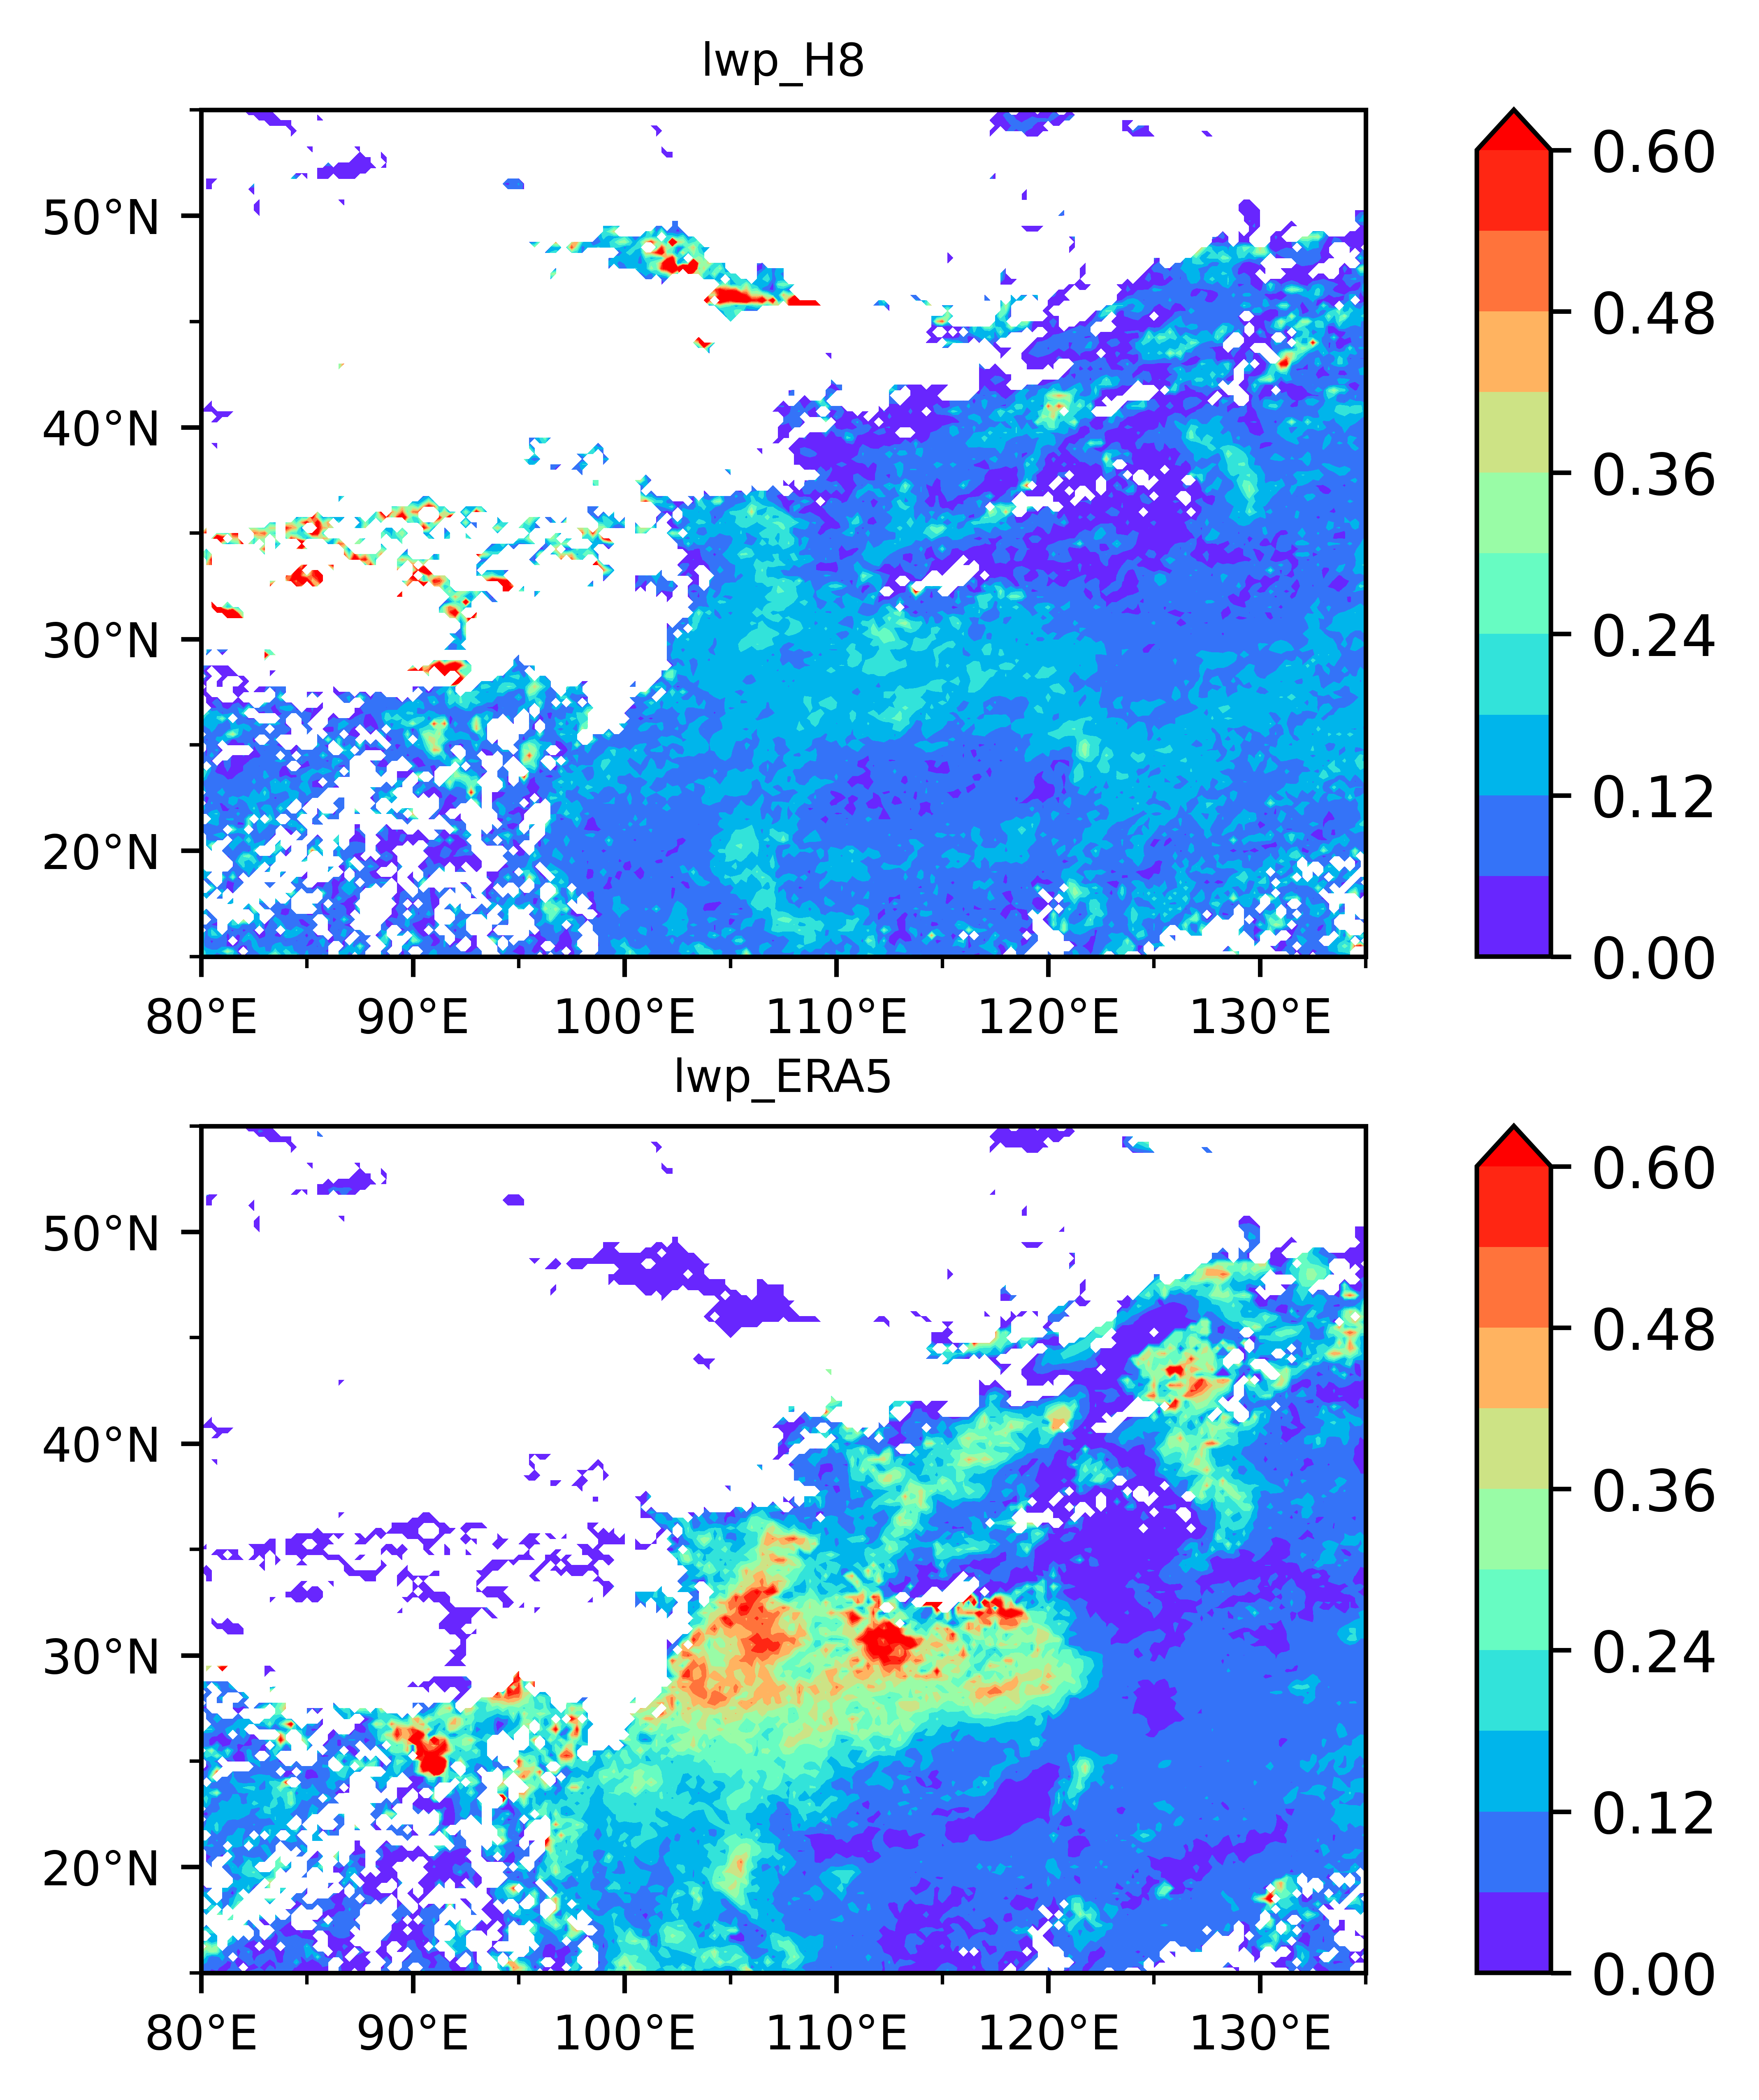

In [128]:
# levels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]
# levels = np.linspace(0, 50, 20)
# plt.close()
Plot_22_pic(H8array_lwp, ERA5array_lwp, 'origin_lwp_10', 'lwp_H8', 'lwp_ERA5', 'rainbow')

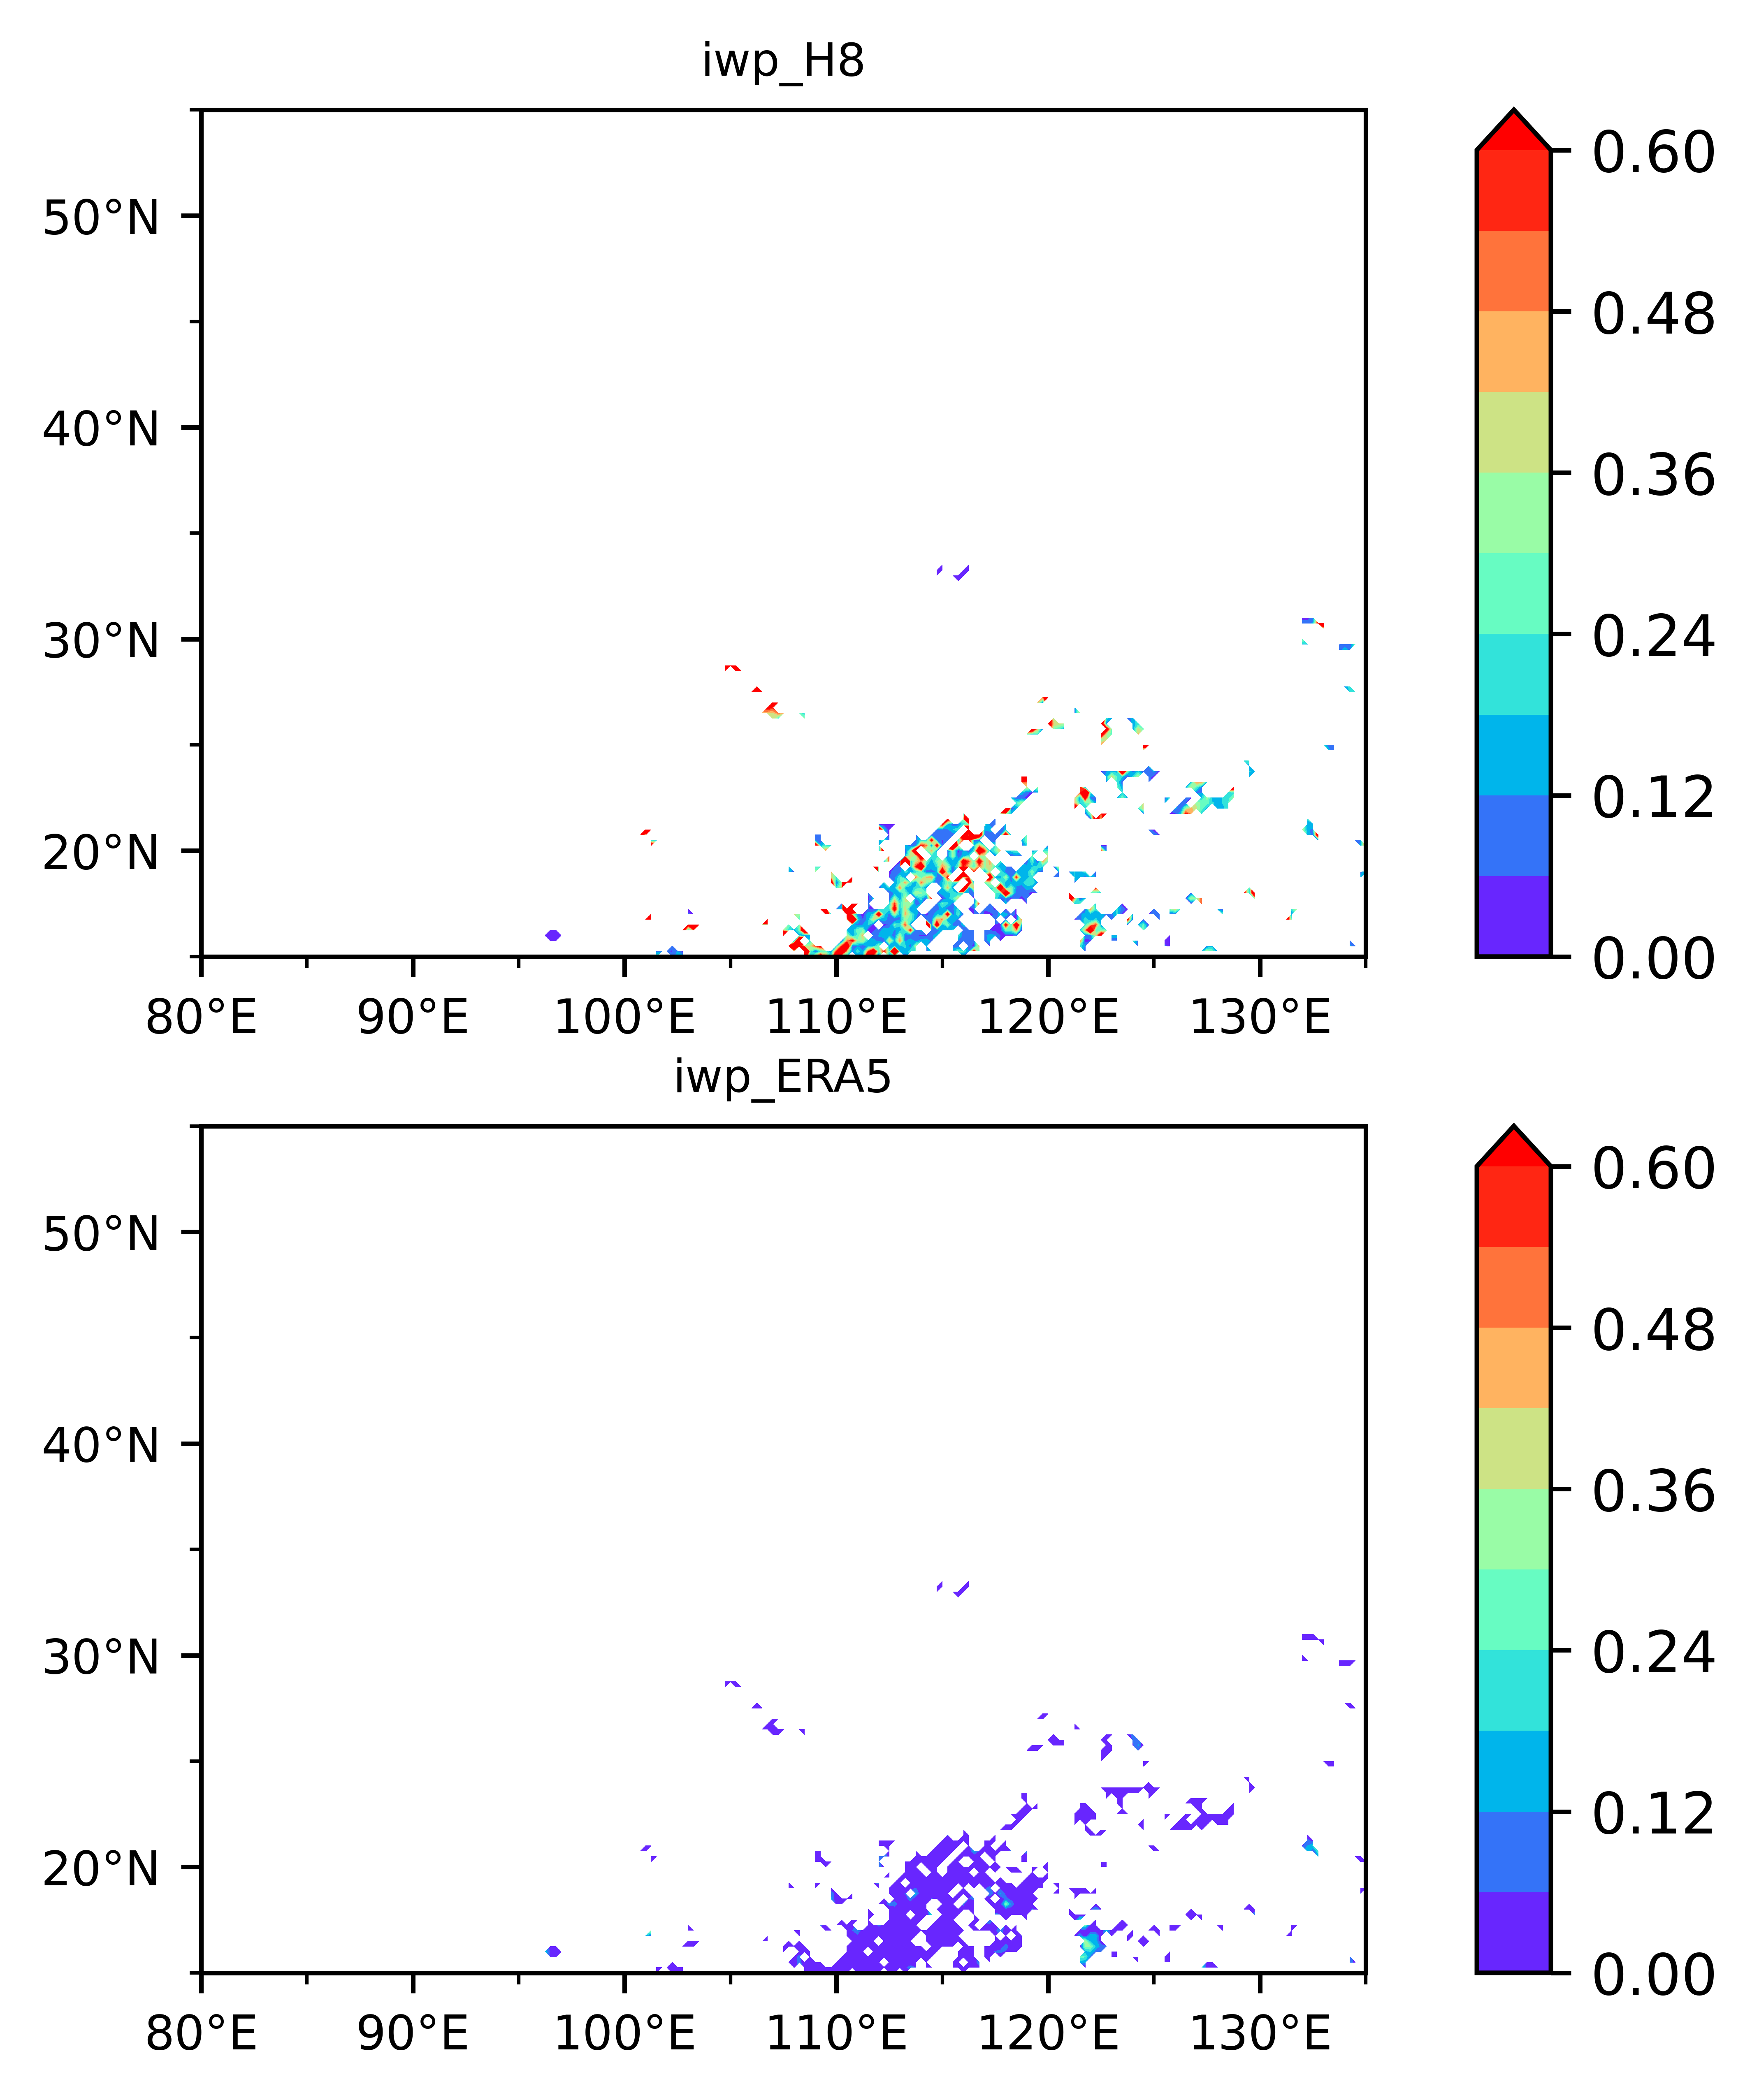

In [129]:
# levels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]
# plt.close()
Plot_22_pic(H8array_iwp, ERA5array_iwp, 'origin_iwp_10', 'iwp_H8', 'iwp_ERA5', 'rainbow')

In [130]:
# ds = xr.open_dataset(r'E:\ZiYuanPingGu\result2\01.nc')
# ds

In [131]:
month = eval(input())
if month == 1:
    ds = xr.Dataset({'H8_lwp_mm':(('lat', 'lon'), H8array_lwp),
                    'H8_iwp_mm':(('lat', 'lon'),H8array_iwp),
                    'ERA5_lwp_mm':(('lat', 'lon'),ERA5array_lwp),
                    'ERA5_iwp_mm':(('lat', 'lon'),ERA5array_lwp),
                    'bias_ERA5lwp':(('lat', 'lon'),array_Biaslwp),
                    'bias_ERA5iwp':(('lat', 'lon'),array_Biasiwp)
                    },
                    coords={
                        'lat':(y),
                        'lon':(x)
                    })
    ds.to_netcdf('E:/ZiYuanPingGu/2022-bias-result/2022-01.nc')#储存计算的所有有用数据
else:
    ds['H8_lwp_mm'] = (('lat', 'lon'), H8array_lwp)
    ds['H8_iwp_mm'] = (('lat', 'lon'), H8array_iwp)
    ds['bias_ERA5lwp'] = (('lat', 'lon'), array_Biaslwp)
    ds['bias_ERA5iwp'] = (('lat', 'lon'), array_Biasiwp)
    ds['ERA5_lwp_mm'] = (('lat', 'lon'), ERA5array_lwp)
    ds['ERA5_iwp_mm'] = (('lat', 'lon'), ERA5array_iwp)
    ds.to_netcdf(f'E:/ZiYuanPingGu/2022-bias-result/2022-{month:02}.nc')#储存计算的所有有用数据